<a href="https://colab.research.google.com/github/fleeash/-.c/blob/master/Mushroom_classification_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN을 이용한 버섯분류


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rembg

In [ ]:
rm /content/drive/MyDrive/deeplearning/temp/train/temp

rm: cannot remove '/content/drive/MyDrive/deeplearning/temp/train/temp': No such file or directory


In [ ]:
%cd /bin

/usr/bin


In [ ]:
%cd /content/drive/MyDrive/deeplearning/img

!unzip -qq "/content/drive/MyDrive/deeplearning/img/data.zip"

/content/drive/MyDrive/deeplearning/img
replace mushroom/edable/0001_yB5GiXfgyRU.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#데이터 학습에 필요한 라이브러리를 임포트합니다.
import os
import shutil
import pandas as pd
from keras import layers, models
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.applications import VGG16

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Settings for displaying charts  차트 시각화 설정
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

NameError: ignored

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #  TensorFlow가 더 나은 성능을 위해 데이터 로드 프로세스를 컴퓨터 성능에 맞게 자동으로 최적화할 수 있도록 함.
IMG_SIZE = 299               # 입력 이미지의 원하는 크기(픽셀 단위)를 설정.
BATCH_SIZE = 64              # 각 교육 반복에서 처리되는 샘플 수를 결정

In [ ]:
# Path to the folder with 9 classes of images:
data_path = '/content/drive/MyDrive/deeplearning/img/mushroom'
os.chdir("/content/drive")

In [ ]:
# Temporary folders for training, validation and test images:
#os.mkdir('MyDrive/deeplearning/temp')
os.chdir('MyDrive/deeplearning/temp')
os.mkdir('train')
os.mkdir('valid')
os.mkdir('test')
os.mkdir('MyDrive/deeplearning/working')
os.chdir('MyDrive/deeplearning/working')

FileExistsError: ignored

In [ ]:

# Split images (75%/15%/10%) and save to temporary folders:
for subfolder in os.listdir(data_path):

    # Making a list of all files in current subfolder:
    original_path = f'{data_path}/{subfolder}'
    original_data = os.listdir(original_path)

    # Number of samples in each group:
    n_samples = len(original_data)
    train_samples = int(n_samples * 0.75)
    valid_samples = int(n_samples * 0.9)
        
    train_path = f'/content/drive/MyDrive/deeplearning/temp/train/{subfolder}'
    valid_path = f'/content/drive/MyDrive/deeplearning/temp/valid/{subfolder}'
    test_path = f'/content/drive/MyDrive/deeplearning/temp/test/{subfolder}'
    
    # New class subfolder for training:
    os.chdir('/content/drive/MyDrive/deeplearning/temp/train/')
    os.mkdir(subfolder)
    
    #Training images:
    for image in range(train_samples):
       original_file = f'{original_path}/{original_data[image]}'
       new_file = f'{train_path}/{original_data[image]}'
       shutil.copyfile(original_file, new_file)
    
    # New class subfolder for validation: 
    os.chdir('/content/drive/MyDrive/deeplearning/temp/valid/')
    os.mkdir(subfolder)
    
    # Validation images:
    for image in range(train_samples, valid_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{valid_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for testing:
    os.chdir('/content/drive/MyDrive/deeplearning/temp/test/')
    os.mkdir(subfolder)
    
    # Test images:
    for image in range(valid_samples, n_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{test_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

FileExistsError: ignored

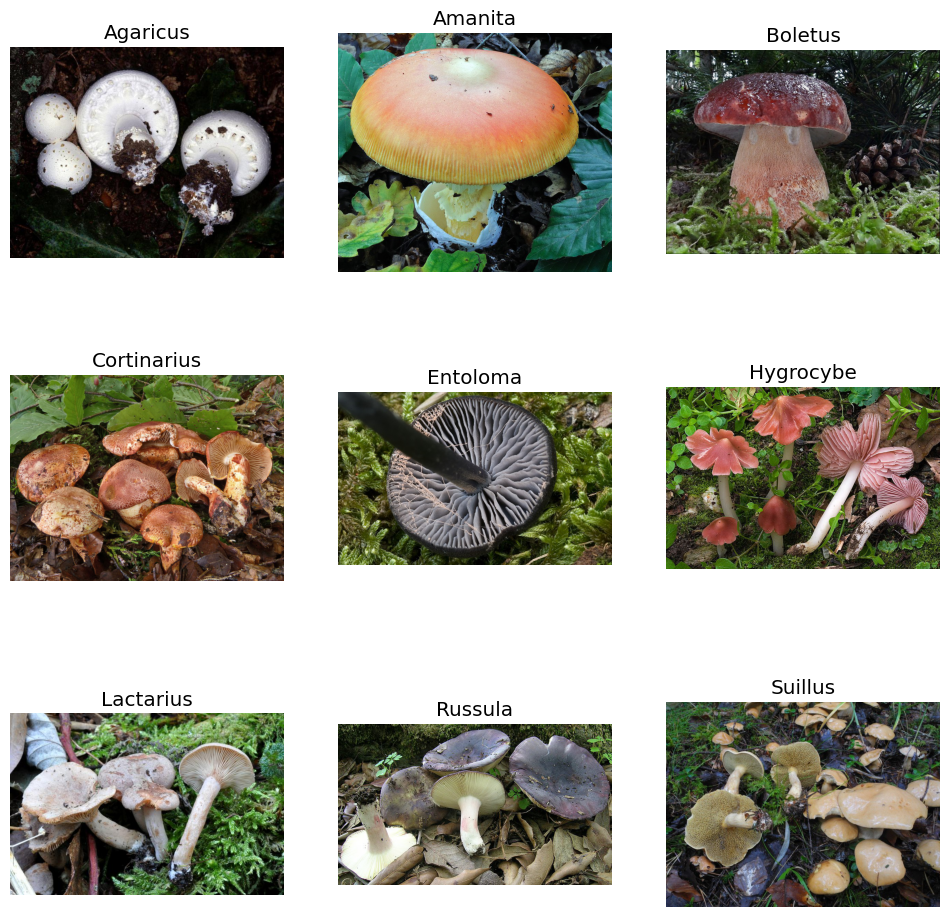

In [ ]:
# Displaying examples from each class
nrows = 3
ncols = 3

pos = 0

for subfolder in os.listdir(data_path):
    
    image_file = os.listdir(os.path.join(data_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(data_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

In [ ]:
# Create image datasets
# 학습 데이터 세트를 나타냄
# preprocessing_function=preprocess_input: 입력 이미지에 적용할 전처리 함수를 지정
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/drive/MyDrive/deeplearning/temp/train',
                                         target_size=(IMG_SIZE, IMG_SIZE),  # 이미지 크기는 위에서 정한 사이즈
                                         class_mode='categorical',          # 이미지의 레이블이 범주형 원-핫 벡터로 인코딩됨
                                         batch_size=BATCH_SIZE,             # 각 데이터 배치의 샘플 수 지정
                                         shuffle=True)                      # 이미지 샘플의 순서를 섞음
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/drive/MyDrive/deeplearning/temp/valid',
                                         target_size=(IMG_SIZE, IMG_SIZE),  # 이미지 크기는 위에서 정한 사이즈
                                         class_mode='categorical',          # 이미지의 레이블이 범주형 원-핫 벡터로 인코딩됨
                                         batch_size=BATCH_SIZE,             # 각 데이터 배치의 샘플 수 지정
                                         shuffle=True)                      # 이미지 샘플의 순서를 섞음
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/drive/MyDrive/deeplearning/temp/test',
                                         target_size=(IMG_SIZE, IMG_SIZE),  # 이미지 크기는 위에서 정한 사이즈
                                         class_mode='categorical',          # 이미지의 레이블이 범주형 원-핫 벡터로 인코딩됨
                                         batch_size=BATCH_SIZE,             # 각 데이터 배치의 샘플 수 지정
                                         shuffle=True)                      # 이미지 샘플의 순서를 섞음

Found 5033 images belonging to 9 classes.
Found 1005 images belonging to 9 classes.
Found 676 images belonging to 9 classes.


In [ ]:
# Pretrained EfficientNetB7 image classification model without final layers
# EfficientNetB7 아키텍처를 사용하여 'feature_model'이라는 특징 추출 모델을 만듬,
# 이 모델은 ImageNet이라는 대규모 이미지 데이터 세트에서 사전 훈련된 모델.
feature_model = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                     include_top=False, #  특정 범주를 예측하기 위해 모델을 사용하는 대신 이미지에서 기능을 추출하는 데 사용
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3), # 이미지 예상 크기(IMG_SIZE)와 3가지 색상(빨강, 녹색, 파랑)
                                                     pooling='avg')     # 풀링을 글로벌 평균 풀링으로 설정함
# ^ 요약 : 이 코드는 특징 추출을 위해 사전 훈련된 EfficientNetB7 모델을 설정한는 것
feature_model.summary()

258076736/258076736 [==============================] - 2s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 299, 299, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Resc

In [ ]:
# Construct a new model with the final dense layer for 9 classes
new_model = tf.keras.models.Sequential(
    [
        feature_model,      # 특징 추출 모델
        tf.keras.layers.Dense(9, activation='softmax')    # 9개의 유닛으로 새로운 dense 레이어를 생성. 활성화 함수가 softmax
    ]
)

In [ ]:
new_model.layers[0].trainable = False

'new_model'에 있는 첫 번째 레이어('feature_model')의 'trainable' 속성을 'False'로 설정하여 특징 추출 모델의 미리 훈련된 가중치가 훈련 중에 업데이트되지 않도록 함.

In [ ]:
# Metrics and optimizer
new_model.compile(loss='categorical_crossentropy', # 손실함수 지정 
                  optimizer='adam',                # 교육 중에 사용할 최적화 알고리즘을 adam으로 정의
                  metrics=['accuracy'])            # 모델의 성능을 평가하기 위한 기준으로 '정확도'를 선택, 정확도는 올바르게 분류된 샘플의 비율을 측정

# 손실 함수, 옵티마이저 및 메트릭으로 모델을 컴파일하면 학습 준비가 완료됩니다.
# 컴파일된 모델을 지정된 손실 함수, 옵티마이저 및 메트릭을 사용하여 훈련 데이터 세트에서 훈련하여 성능을 평가할 수 있습니다.

In [ ]:
# Check the architecture of the new model
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dense (Dense)               (None, 9)                 23049     
                                                                 
Total params: 64,120,736
Trainable params: 23,049
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', # 정확도를 모니터링함.
                                              patience=10,            # 10번 같으면 중지
                                              restore_best_weights=True) # 가장 값이 높은 모델을 가져옴

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', # 정확도를 모니터링함 
                                                 factor=0.1,            # 검증 정확도가 정체되면 학습률을 0.1배 줄임.
                                                 mode='max',            # 정확도가 증가하지 않으면 학습속도를 감소시킴
                                                 cooldown=2,            # 학습률이 감소 후 반복 수(epoch)를 2로 설정
                                                 patience=2,            # 2번(epoch) 횟수 내에 정확도가 개선되지 않으면 학습률 감소
                                                 min_lr=0)              # 학습률의 하한 설정
# reduce_lr 은 과적합을 방지하는데 유용함

In [ ]:
# Train new model:
history = new_model.fit(train_generator,                  # 훈련 샘플 배치와 해당 레이블을 생성하는 훈련 데이터 생성기
                        validation_data=valid_generator,  # 검사 데이터 생성, 데이터는 학습 중 모델의 성능을 평가하는 데 사용
                        epochs=100,                       # 훈련횟수 100번
                        steps_per_epoch=79,               # Epoch당 79개의 훈련 데이터 배치가 처리됨
                        validation_steps=16,              # 각 평가 중에 16개의 유효성 검사 데이터 배치가 처리됨
                        verbose=2,                        # 학습 프로세스의 자세한 정도를 제어. 2로 설정하면 각 epoch에 대한 진행률 표시줄이 표시
                        callbacks=[reduce_lr, early_stop],# reduce_lr 및 early_stop 콜백이 적용
                        use_multiprocessing=True,         # 다중 처리 사용을 활성화
                        workers=2)                        # 데이터 로드에 사용할 작업자 프로세스 수를 지정, 데이터 로드 프로세스의 속도를 높임.
# 'fit()' 함수는 지정된 매개변수를 사용하여 'new_model'을 훈련하고, 훈련 진행률과 메트릭은 'history' 변수에 저장

NameError: ignored

In [ ]:
print("--Predict--")
output = model.predict_generator(test_generator, steps = 5) # 훈련된 모델을 사용하여 테스트 데이터 세트를 예측, 예측된 출력은 'output' 변수에 저장
np.set_printoptions(formatter = {'float' : lambda x : "{0:0.3f}".format(x)}) # numpy 배열에 대한 출력 옵션을 설정
print(test_generator.class_indices) #  테스트 생성기의 클래스 인덱스를 출력
print(output)                       # 테스트 데이터 세트에 대한 예측을 출력

# 훈련된 모델을 사용하여 테스트 데이터 세트에서 예측을 수행한 다음 예측된 결과를 출력

--Predict--


NameError: ignored